In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# save filepath to variable for easier access
weedbusts_file_path = 'data/Marijuana_Data.csv'
weedbusts_data = pd.read_csv(weedbusts_file_path)

In [3]:
weedbust_features = ['Arrest Date', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Location']
# Descent Code is race; Reporting District is numerical; location is a lat/long pair with ()s and comma.

X = weedbusts_data[weedbust_features]

In [4]:
lat_long = X['Location'].str.strip('()').str.split(',', expand=True) # returns Series, not affecting actual df

X = X.assign(Latitude = lat_long[0], Longitude = lat_long[1])

# X.describe

In [5]:
X = X.assign(ArrestDateObj = pd.to_datetime(X['Arrest Date']))

X.columns

Index(['Arrest Date', 'Time', 'Area ID', 'Area Name', 'Reporting District',
       'Age', 'Sex Code', 'Descent Code', 'Charge Group Code',
       'Arrest Type Code', 'Charge', 'Charge Description', 'Location',
       'Latitude', 'Longitude', 'ArrestDateObj'],
      dtype='object')

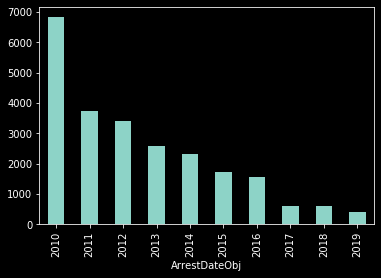

In [6]:
# stick with just year, for simplicity
grouped = X.groupby([X["ArrestDateObj"].dt.year]).count()
grouped['ArrestDateObj'].plot(kind='bar') # use count of arrests col


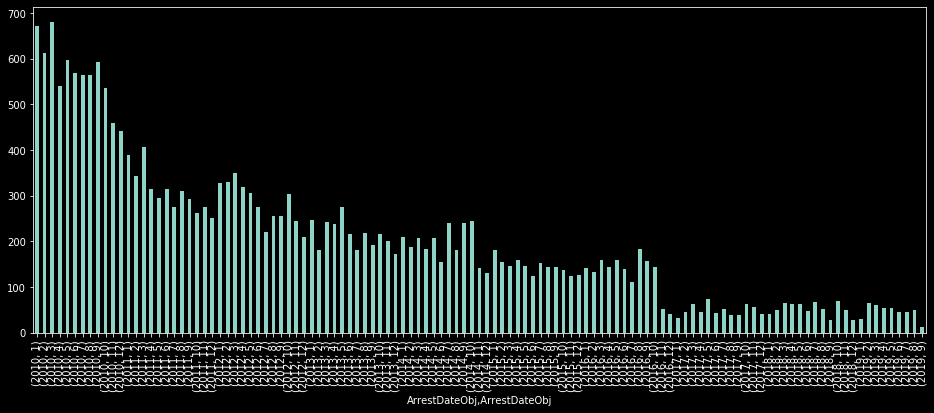

In [7]:
# https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates#29036738
grouped = X.groupby([X["ArrestDateObj"].dt.year, X["ArrestDateObj"].dt.month])['ArrestDateObj'] # .count()
grouped_count = grouped.count()
grouped_count.plot(kind='bar', figsize=(16,6))

**Clean Data & make years easier to change**

Gonna set that aside and look at claning up data, e.g., for 2010 data there was at least one 0,0 point that wrecked the chart.

***YEAR 2010 DATA***

/Users/wes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/wes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


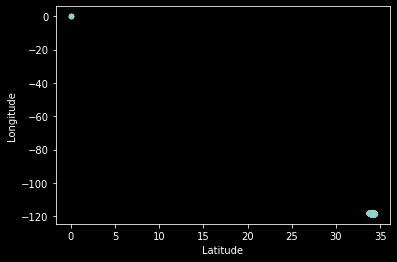

In [8]:
subset_year = 2010
subset = X.loc[X["ArrestDateObj"].dt.year == subset_year]
locs_subset = subset[['Latitude','Longitude']]
locs_subset['Latitude'] = locs_subset['Latitude'].astype('float64')
locs_subset['Longitude'] = locs_subset['Longitude'].astype('float64')
locs_subset.plot('Latitude','Longitude', kind='scatter')

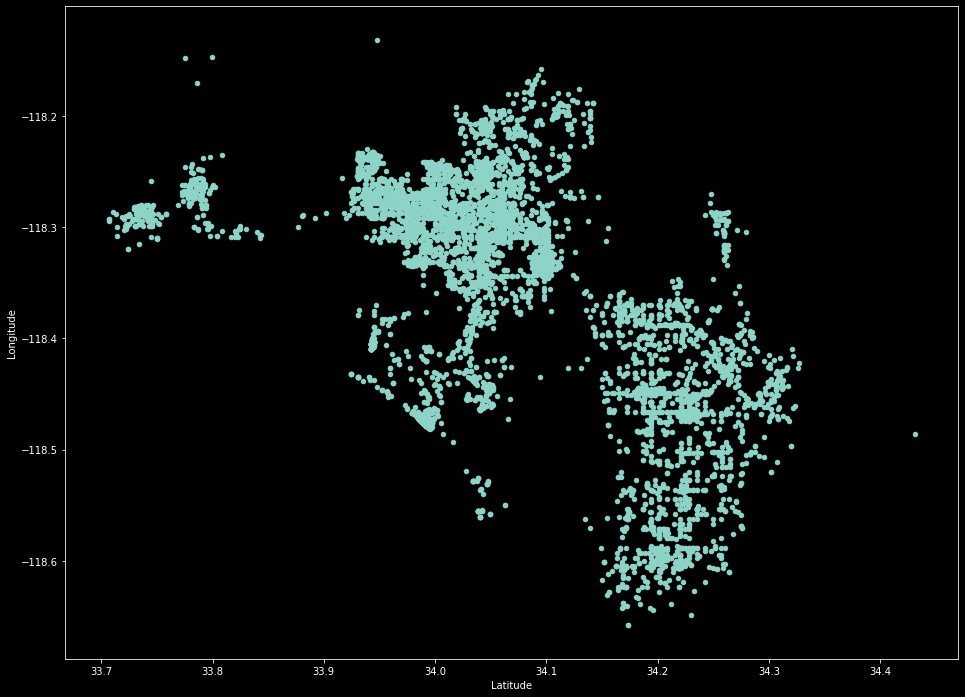

In [9]:
# remove outliers and plot

# 'keep only' action example: df[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]
# NOTE: This doesn't remove data permanently, only in this 1-liner plot command.
locs_subset[(locs_subset.Latitude != 0) & (locs_subset.Longitude < -118.0)].plot('Latitude','Longitude', kind='scatter', figsize=(16,12))

In [10]:
import geopandas as gp
import folium

avg_lat = locs_subset.Latitude.mean()
avg_lon = locs_subset.Longitude.mean()

m = folium.Map(location=[avg_lat,avg_lon],zoom_start = 14)


In [11]:
# add a marker for every record in the filtered data, use a clustered view
for index, bust in locs_subset[:].iterrows():  # interrows outputs [index,Series] naturally, so split on for statement to avoid having to [1] index later
    folium.Circle(
        location = [bust['Latitude'], bust['Longitude']], 
        radius=3, # units: meters
        color='crimson',
        popup=None,
        fill=True,
        fill_color='crimson',
    ).add_to(m)
  
# m
# map won't load in VS Code because it requires rendering html

In [ ]:
#create numpy array of locations for heatmap
list = []

for index, bust in locs_subset[:].iterrows():
    list.append(([bust['Latitude'], bust['Longitude']]))

arr = np.array(list)

# create heatmap
from folium.plugins import HeatMap as heatMap
hm = heatMap(arr)

hm.add_to(m)

In [ ]:
# Save map html to file instead

import os
import webbrowser
filepath = '/Users/wes/Projects/WeedArrestFromScratch/output/map.html'
m.save(filepath)
webbrowser.open('file://' + filepath)